In [130]:
from torchvision import datasets,transforms
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

%matplotlib inline
import matplotlib.pyplot as plt

device='cuda'

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.view(-1))
])

dataset_train = datasets.MNIST(
    './mnist',
    train=True,
    download=True,
    transform=transform
)

dataset_valid = datasets.MNIST(
    './mnist',
    train=False,
    download=True,
    transform=transform
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size = 1000,
    shuffle = True,
    num_workers = 4
)

dataloader_valid = DataLoader(
    dataset_valid,
    batch_size = 1000,
    shuffle = True,
    num_workers = 4
)

In [16]:

class VAE(nn.Module):
    def __init__(self, z_dim):
      super(VAE, self).__init__()
      self.dense_enc1 = nn.Linear(28*28, 200)
      self.dense_enc2 = nn.Linear(200, 200)
      self.dense_encmean = nn.Linear(200, z_dim)
      self.dense_encvar = nn.Linear(200, z_dim)
      self.dense_dec1 = nn.Linear(z_dim, 200)
      self.dense_dec2 = nn.Linear(200, 200)
      self.dense_dec3 = nn.Linear(200, 28*28)
    
    def _encoder(self, x):
      x = F.relu(self.dense_enc1(x))
      x = F.relu(self.dense_enc2(x))
      mean = self.dense_encmean(x)
      var = F.softplus(self.dense_encvar(x))
      return mean, var
    
    def _sample_z(self, mean, var):
      epsilon = torch.randn(mean.shape).to(device)
      return mean + torch.sqrt(var) * epsilon
 
    def _decoder(self, z):
      x = F.relu(self.dense_dec1(z))
      x = F.relu(self.dense_dec2(x))
      x = F.sigmoid(self.dense_dec3(x))
      return x

    def forward(self, x):
      mean, var = self._encoder(x)
      z = self._sample_z(mean, var)
      x = self._decoder(z)
      return x, z
    
    def loss(self, x):
      mean, var = self._encoder(x)
      KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
      z = self._sample_z(mean, var)
      y = self._decoder(z)
      reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
      lower_bound = [-KL, reconstruction]                                      
      return -sum(lower_bound)

In [17]:

model = VAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for i in range(20):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      model.zero_grad()
      y = model(x)
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy() )
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

/home/user/PycharmProjects/auto_encoder/venv/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 0 loss: 270379.4375
EPOCH: 1 loss: 200142.078125
EPOCH: 2 loss: 189936.15625
EPOCH: 3 loss: 178850.84375
EPOCH: 4 loss: 161317.640625
EPOCH: 5 loss: 151481.34375
EPOCH: 6 loss: 144881.171875
EPOCH: 7 loss: 139073.828125
EPOCH: 8 loss: 135409.734375
EPOCH: 9 loss: 132478.28125
EPOCH: 10 loss: 129927.140625
EPOCH: 11 loss: 128042.015625
EPOCH: 12 loss: 126415.8046875
EPOCH: 13 loss: 124864.65625
EPOCH: 14 loss: 123196.46875
EPOCH: 15 loss: 121773.5234375
EPOCH: 16 loss: 120135.359375
EPOCH: 17 loss: 118890.6015625
EPOCH: 18 loss: 117834.390625
EPOCH: 19 loss: 117012.921875


/home/user/PycharmProjects/auto_encoder/venv/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/user/PycharmProjects/auto_encoder/venv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


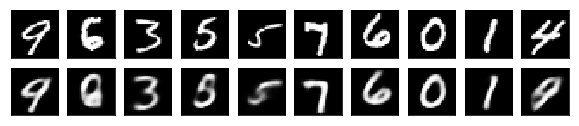

In [91]:

fig = plt.figure(figsize=(10,3))

model.eval()
zs = []
for x, t in dataloader_valid:
    # original
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x.to(device)
    # generate from x
    
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')

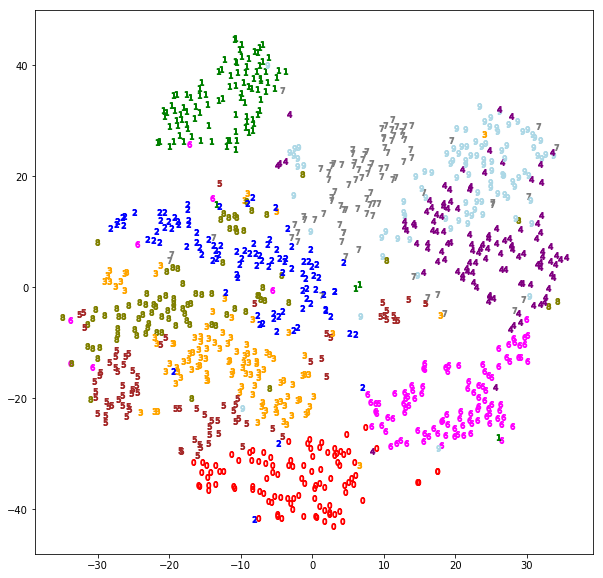

In [92]:
colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs,labels):
    plt.figure(figsize=(10,10))
    points = TSNE(n_components=2,random_state=0).fit_transform(zs)
    for p,l in zip(points,labels):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])
    plt.show()
    
model.eval()
zs = []
ts = []
for x,t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    
    y,z = model(x)
    z = z.cpu()
    t = t.cpu()
    zs = z
    ts = t
    visualize_zs(z.detach().numpy(),t.cpu().detach().numpy())
    break

In [ ]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=10)

In [94]:
points = TSNE(n_components=2,random_state=0).fit_transform(zs.detach().numpy())


In [95]:
points


array([[ -9.258399 ,  39.895416 ],
       [-20.534334 ,  -8.928381 ],
       [-26.655867 , -19.354055 ],
       ...,
       [-12.467283 , -33.17311  ],
       [ -1.4641994, -15.785934 ],
       [ 13.138152 ,  10.355289 ]], dtype=float32)

In [96]:
ts.cpu().detach().numpy()

array([1, 5, 5, 3, 6, 9, 1, 6, 4, 9, 4, 9, 6, 6, 1, 1, 3, 5, 5, 9, 0, 0,
       4, 0, 4, 7, 1, 3, 8, 1, 0, 6, 1, 8, 2, 9, 6, 4, 5, 3, 2, 0, 5, 2,
       2, 2, 7, 6, 0, 2, 4, 9, 7, 8, 3, 0, 6, 4, 9, 1, 3, 3, 2, 2, 7, 9,
       0, 1, 8, 4, 3, 6, 8, 4, 3, 4, 1, 1, 1, 5, 3, 8, 0, 5, 4, 4, 3, 5,
       0, 8, 7, 2, 7, 5, 1, 4, 0, 8, 0, 7, 8, 9, 3, 2, 5, 4, 1, 8, 0, 0,
       4, 5, 1, 8, 8, 2, 5, 7, 1, 7, 0, 6, 3, 4, 7, 5, 2, 4, 5, 5, 4, 2,
       0, 7, 2, 3, 1, 9, 0, 9, 1, 1, 5, 4, 5, 9, 0, 0, 9, 7, 0, 3, 4, 9,
       2, 4, 1, 3, 3, 7, 3, 4, 3, 4, 6, 7, 5, 2, 1, 8, 2, 7, 8, 8, 2, 9,
       0, 7, 3, 6, 3, 7, 8, 0, 2, 1, 3, 3, 6, 3, 0, 3, 5, 9, 7, 0, 2, 6,
       6, 5, 1, 5, 9, 8, 2, 3, 2, 5, 4, 9, 4, 6, 8, 7, 4, 6, 1, 4, 9, 0,
       6, 3, 3, 1, 3, 0, 3, 4, 9, 7, 1, 9, 9, 5, 6, 4, 8, 5, 6, 1, 6, 5,
       2, 7, 1, 5, 8, 9, 8, 8, 2, 6, 5, 3, 3, 2, 7, 7, 9, 5, 6, 3, 8, 1,
       3, 4, 2, 5, 7, 9, 3, 8, 5, 2, 3, 3, 4, 6, 3, 3, 5, 7, 1, 1, 2, 7,
       0, 4, 5, 9, 5, 5, 3, 7, 0, 9, 0, 3, 5, 7, 5,

In [124]:
kmean.fit(points)
kmean.cluster_centers_

array([[ 18.572952  , -21.869802  ],
       [ -1.0884173 ,  -0.15901251],
       [-16.258476  ,   9.085736  ],
       [ 25.533062  ,   2.8813853 ],
       [-24.08167   , -10.506285  ],
       [-12.23803   ,  34.14874   ],
       [ -3.30459   , -34.463905  ],
       [ 24.94874   ,  21.979576  ],
       [ -8.939001  , -18.552767  ],
       [  7.5923758 ,  19.358349  ]], dtype=float32)

In [98]:
np.array(kmean.labels_)
colorsarray = np.array(["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"])


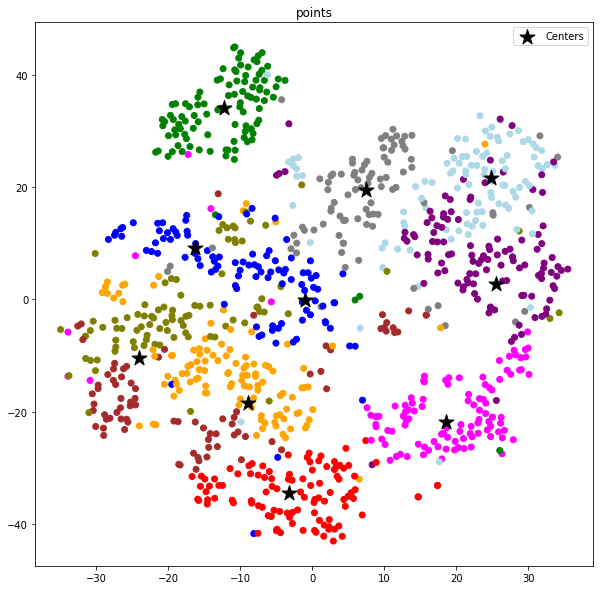

In [104]:
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(points[:,0],points[:,1],c=colorsarray[ts.cpu().detach().numpy()])
ax.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],marker='*',s=250,color='black',label='Centers')
ax.set_title("points")
ax.legend(loc='best')#凡例を置く位置

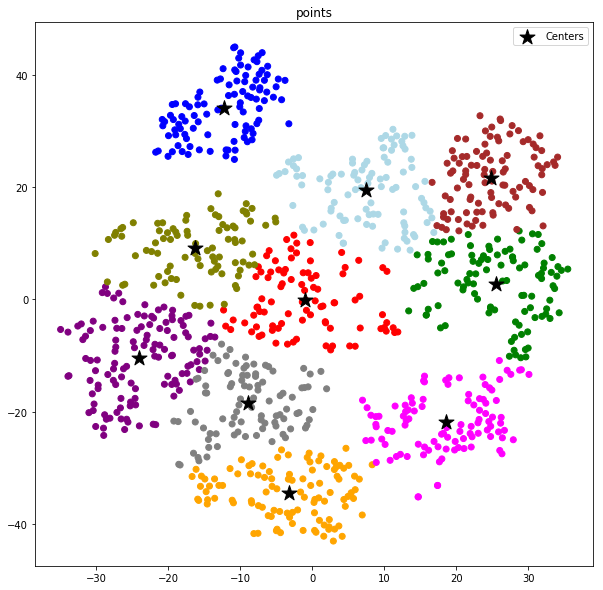

In [102]:
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(points[:,0],points[:,1],c=colorsarray[kmean.labels_])
ax.scatter(kmean.cluster_centers_[:,0],kmean.cluster_centers_[:,1],marker='*',s=250,color='black',label='Centers')
ax.set_title("points")
ax.legend(loc='best')#凡例を置く位置

In [105]:
zs.detach().numpy()

array([[ 2.0973783 , -1.6345924 ,  0.32794714, ..., -0.3213982 ,
         0.20233247,  0.40289283],
       [ 0.25606188,  1.7349997 ,  0.7196763 , ..., -0.2776051 ,
         0.40369144, -0.11414997],
       [ 0.23543008,  1.1977005 , -2.4833765 , ...,  0.39353666,
        -0.3634965 , -0.20372944],
       ...,
       [-2.582432  ,  1.0185567 , -1.4028411 , ...,  1.4554315 ,
        -0.6434595 ,  0.12704167],
       [-0.1987781 ,  0.4777605 ,  0.8067217 , ..., -1.0259888 ,
         2.489496  , -0.05156373],
       [ 0.69860834,  0.3650095 ,  0.96532345, ..., -0.29974055,
        -0.43438825, -1.3126665 ]], dtype=float32)

In [122]:
kmean.fit(zs.detach().numpy())
kmean.cluster_centers_

array([[-0.83032495, -1.0966383 ,  0.7576591 ,  0.2167494 , -1.7091695 ,
        -0.5534601 , -1.4005643 ,  0.6386336 , -0.07601988, -0.09562466],
       [ 0.62858975,  0.45221373, -0.08328968, -0.6209513 ,  0.27261955,
        -0.49855834, -0.26050293,  1.0538224 ,  0.96205795,  1.2670919 ],
       [-1.5220609 ,  0.32307306, -0.03885405,  0.02084637,  0.503851  ,
         0.5690304 ,  0.82770276,  0.38897273,  0.7693361 , -0.7194693 ],
       [ 0.43857378, -1.0520668 , -0.06990685,  1.0099373 ,  0.5207661 ,
        -0.30305168, -0.16801779,  1.5028564 , -0.22339979, -0.34009492],
       [-0.32403558,  0.7751223 , -1.3260571 ,  0.5049016 ,  0.01474504,
        -0.31849745,  0.34829557,  0.01675818, -0.86305773,  0.04621072],
       [ 1.9826443 , -0.438456  , -0.0650811 ,  0.2402917 , -0.13564081,
        -0.2496031 , -0.05739955, -1.3045425 ,  0.01768873,  0.27391642],
       [-0.46888018,  1.0812374 ,  0.8283369 ,  0.5515317 , -0.5951551 ,
        -0.18250978,  0.4999394 , -0.5956066 

In [107]:
kmean.labels_

array([4, 6, 9, 0, 8, 3, 4, 8, 5, 3, 3, 3, 8, 5, 4, 4, 6, 9, 3, 3, 1, 1,
       7, 1, 7, 2, 4, 9, 9, 4, 1, 8, 4, 6, 0, 3, 8, 5, 1, 1, 2, 1, 9, 5,
       2, 2, 7, 8, 1, 2, 5, 3, 3, 6, 0, 1, 5, 7, 7, 4, 6, 2, 9, 0, 7, 3,
       9, 4, 6, 5, 6, 8, 6, 7, 6, 3, 4, 2, 4, 9, 1, 2, 9, 7, 7, 3, 6, 7,
       1, 9, 7, 2, 3, 9, 4, 7, 0, 6, 0, 2, 6, 7, 1, 2, 9, 7, 4, 6, 1, 1,
       7, 9, 4, 0, 9, 2, 9, 4, 4, 3, 1, 8, 6, 5, 2, 9, 0, 5, 9, 1, 7, 2,
       1, 2, 2, 1, 4, 7, 1, 3, 2, 4, 9, 5, 0, 7, 1, 1, 3, 3, 9, 6, 7, 3,
       0, 5, 9, 6, 6, 2, 0, 7, 6, 5, 8, 3, 6, 2, 4, 6, 2, 3, 6, 9, 2, 7,
       3, 2, 6, 8, 9, 0, 2, 1, 2, 2, 6, 1, 8, 6, 1, 6, 9, 3, 7, 1, 5, 8,
       5, 0, 4, 9, 3, 9, 2, 6, 0, 9, 7, 7, 7, 5, 6, 6, 3, 5, 2, 7, 7, 1,
       8, 6, 6, 4, 6, 1, 6, 7, 3, 2, 2, 3, 0, 9, 8, 3, 9, 9, 5, 4, 8, 9,
       0, 7, 2, 9, 2, 3, 9, 6, 2, 8, 9, 9, 6, 6, 7, 2, 3, 9, 8, 6, 6, 4,
       6, 7, 2, 9, 2, 7, 3, 6, 9, 2, 6, 6, 8, 9, 6, 6, 1, 3, 4, 4, 2, 7,
       1, 7, 2, 3, 9, 9, 6, 3, 1, 3, 1, 6, 9, 3, 9,

No handles with labels found to put in legend.


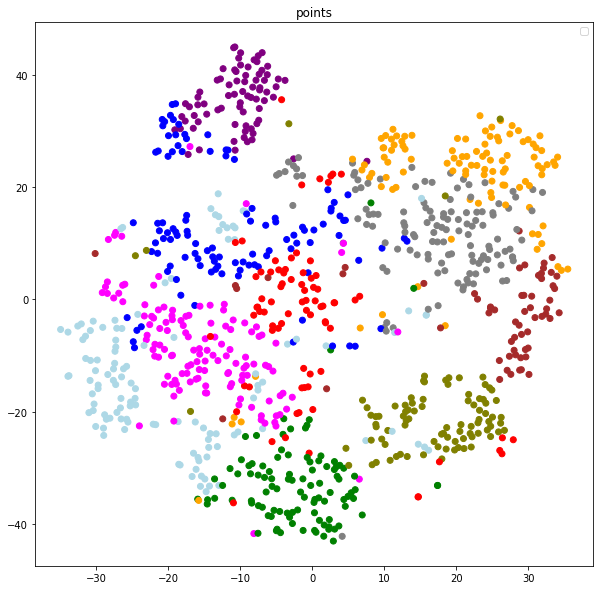

In [118]:
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(points[:,0],points[:,1],c=colorsarray[kmean.labels_])
ax.set_title("points")
ax.legend(loc='best')#凡例を置く位置

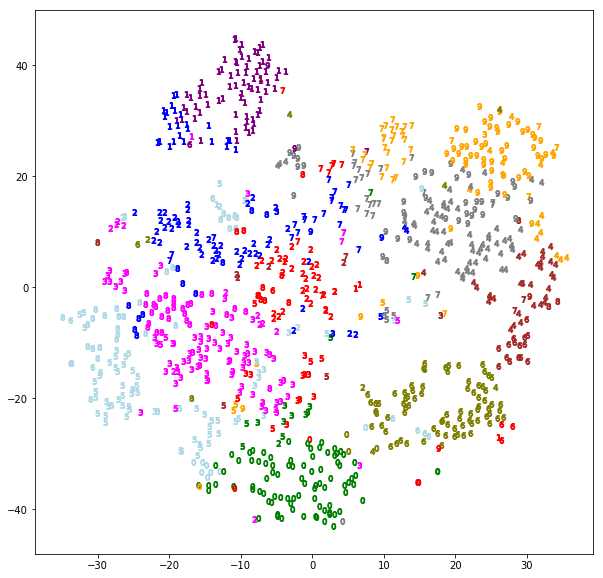

In [121]:
plt.figure(figsize=(10,10))
for p,l,k in zip(points,t.cpu().detach().numpy(),kmean.labels_):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[k])
plt.show()

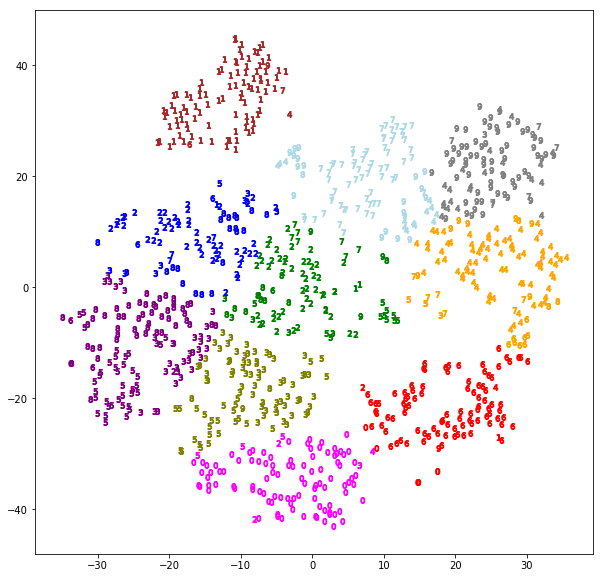

In [128]:
fig2=plt.figure(figsize=(10,10))
for p,l,k in zip(points,t.cpu().detach().numpy(),kmean.labels_):
    plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[k])
plt.show()
fig2.savefig("img2.png")

In [131]:
model3 = BayesianGaussianMixture(n_components=10,covariance_type='full',random_state=6)
model3.fit(points)


/home/user/PycharmProjects/auto_encoder/venv/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=6, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

<function matplotlib.pyplot.show(*args, **kw)>

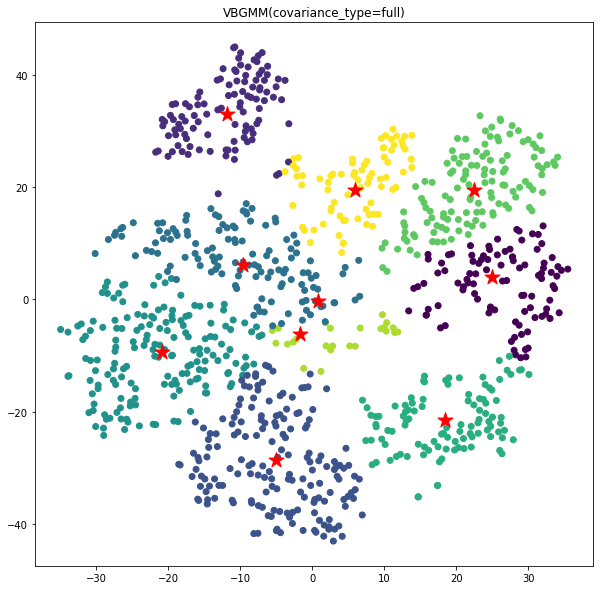

In [134]:
plt.figure(figsize=(10,10))
plt.scatter(points[:,0],points[:,1],c=model3.predict(points))
plt.scatter(model3.means_[:,0],model3.means_[:,1],s=250,marker='*',c='red')
plt.title('VBGMM(covariance_type=full)')

plt.show

In [135]:
model3.weights_

array([0.00107326, 0.10736055, 0.10785745, 0.16722348, 0.11409598,
       0.16658155, 0.10334937, 0.11223643, 0.04140967, 0.07881226])

In [138]:
model2 = GaussianMixture(n_components=10,covariance_type='full',random_state=1)
model2.fit(points)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

<function matplotlib.pyplot.show(*args, **kw)>

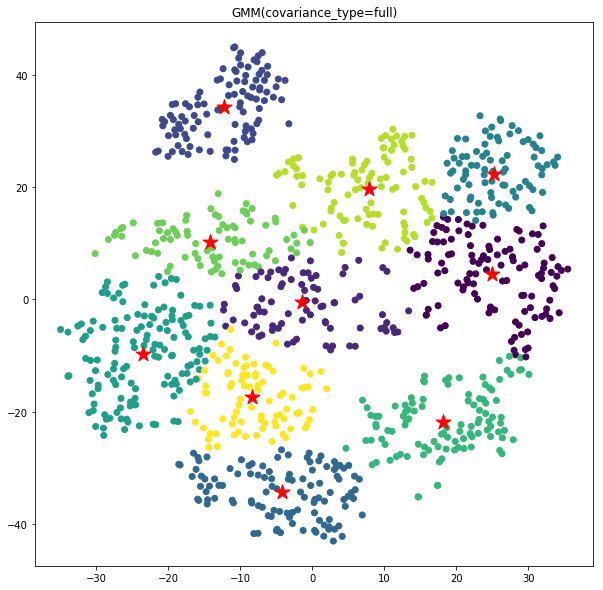

In [139]:
plt.figure(figsize=(10,10))

plt.scatter(points[:,0],points[:,1],c=model2.predict(points))
plt.scatter(model2.means_[:,0],model2.means_[:,1],s=250,marker='*',c='red')
plt.title('GMM(covariance_type=full)')

plt.show

In [142]:
model2.weights_

array([0.11228842, 0.08628078, 0.09998552, 0.10310025, 0.08299089,
       0.13524482, 0.10707551, 0.07581908, 0.1017912 , 0.09542353])

In [ ]:
model4 = BayesianGaussianMixture(n_components=10,covariance_type='full',random_state=6)
model4.fit(zs.detach().numpy())

In [143]:
model4.weights_

array([0.13500171, 0.09476642, 0.12346885, 0.09840134, 0.14226412,
       0.06991197, 0.09350751, 0.10301914, 0.07253027, 0.06712867])

Text(0.5, 1.0, 'VBGMM(covariance_type=full)')

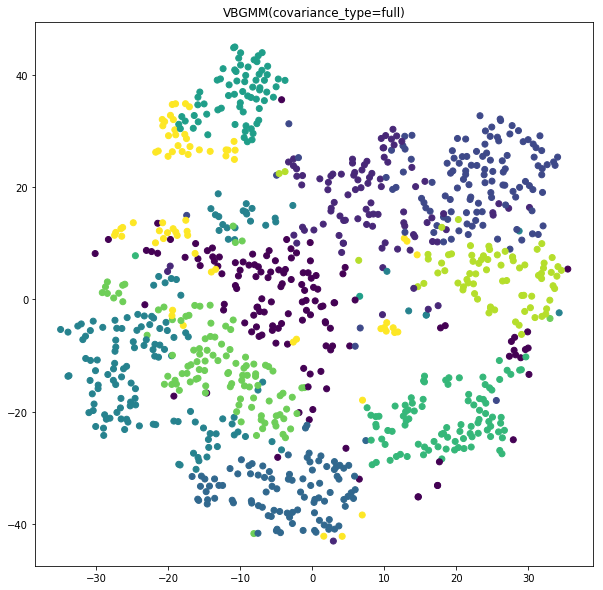

In [145]:
plt.figure(figsize=(10,10))
plt.scatter(points[:,0],points[:,1],c=model4.predict(zs.detach().numpy()))
plt.title('VBGMM(covariance_type=full)')


In [146]:
model5 = GaussianMixture(n_components=10,covariance_type='full',random_state=1)
model5.fit(zs.detach().numpy())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [147]:
model5.weights_

array([0.0751787 , 0.09544752, 0.11370572, 0.10591653, 0.08424854,
       0.09547118, 0.08166848, 0.09105809, 0.14970583, 0.10759942])

ValueError: 
$[1 5 5 7 4 8 1 4 8 8 0 8 4 0 1 1 7 5 5 5 9 9 8 0 8 6 4 7 2 1 9 4 1 2 3 8 2
^
Expected end of text (at char 0), (line:1, col:1)

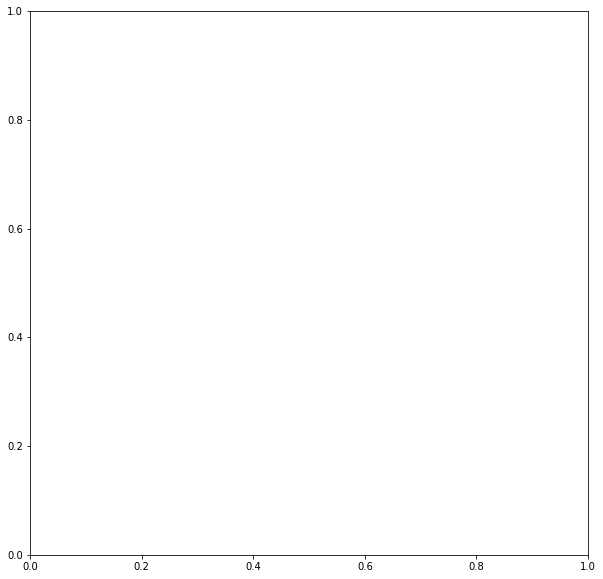

In [155]:
plt.figure(figsize=(10,10))

plt.scatter(points[:,0],points[:,1],marker="${}$".format(model5.predict(zs.detach().numpy())),c=model5.predict(zs.detach().numpy()))
plt.title('GMM(covariance_type=full)')

plt.show
